In [1]:
import torch
import torch.nn as nn
import pandas as pd
from tqdm.notebook import tqdm  # For displaying progress bars
from datasets import load_dataset  # For loading datasets
from sklearn.model_selection import train_test_split  # For splitting the dataset
from transformers import BertTokenizer  # For tokenizing text
from torch.utils.data import TensorDataset  # For creating Tensor datasets
import time  # For measuring time
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score  # For evaluation metrics
from sklearn.exceptions import UndefinedMetricWarning  # For handling metric warnings
import matplotlib.pyplot as plt  # For plotting
from tabulate import tabulate  # For tabular data formatting
import random  # For randomization
import numpy as np  # For numerical operations
from transformers import (
    BertTokenizer,  # Tokenizer for BERT models
    AdamW,  # Optimizer for BERT models
    get_linear_schedule_with_warmup,  # Learning rate scheduler for BERT models
    BertConfig,  # Configuration for BERT models
    BertForSequenceClassification  # BERT model for sequence classification tasks
)
from torch.utils.data import (
    DataLoader,  # Data loader for creating batches
    RandomSampler,  # Sampler for random sampling of data
    SequentialSampler  # Sampler for sequential sampling of data
)
from sklearn.metrics import f1_score  # For computing the F1 score

# 1. Torch: PyTorch library for deep learning
# 2. Pandas: Library for data manipulation and analysis
# 3. tqdm: Library for displaying progress bars
# 4. datasets: Library for working with datasets
# 5. train_test_split: Function for splitting the dataset into training and validation sets
# 6. BertTokenizer: Tokenizer for BERT models
# 7. TensorDataset: Dataset class for creating PyTorch Tensor datasets
# 8. time: Module for measuring time
# 9. accuracy_score, precision_score, f1_score: Evaluation metrics for classification tasks
# 10. UndefinedMetricWarning: Warning for undefined metric values
# 11. matplotlib.pyplot: Plotting library
# 12. tabulate: Library for formatting tabular data
# 13. random: Module for randomization
# 14. numpy: Library for numerical operations
# 15. AdamW: Optimizer for BERT models
# 16. get_linear_schedule_with_warmup: Learning rate scheduler for BERT models
# 17. BertConfig: Configuration for BERT models
# 18. BertForSequenceClassification: BERT model for sequence classification tasks
# 19. DataLoader: Data loader for creating batches
# 20. RandomSampler: Sampler for random sampling of data
# 21. SequentialSampler: Sampler for sequential sampling of data
# 22. f1_score: Function for computing the F1 score

2023-07-10 12:34:13.920666: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 12:34:13.945575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 12:34:14.426660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def datacleaning_imdb():
    dataset = load_dataset("sst2")
    train_data = dataset['train']

    df = train_data.to_pandas()  # Convert the dataset to a Pandas DataFrame

    df['sentiment'] = df['label'].map({0: 'bad', 1: 'good'})

    possible_labels = df.sentiment.unique()  # Get unique category labels from the DataFrame column 'category'

    label_dict = {}  # Create a dictionary to map each possible label to a unique index
    for index, possible_label in enumerate(possible_labels):
        label_dict[possible_label] = index

    df['label'] = df.sentiment.replace(label_dict)

    # Split the dataset into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        df.index.values,
        df.label.values,
        test_size=0.15,
        random_state=17,
        stratify=df.label.values
    )

    df['data_type'] = ['not_set'] * df.shape[0]  # Set a new column 'data_type' for later data split

    # Set the 'data_type' column of the dataframe for training and validation data
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'

    return df

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten() #This line finds the index with the highest probability in each prediction, effectively giving the predicted class for each input.
    labels_flat = labels.flatten()  #This line flattens the labels array into a 1D vector, as required by the f1_score function.
    return f1_score(labels_flat, preds_flat, average='weighted') #This line computes the F1 score using the true labels and the predicted labels, with the weighted averaging scheme. The result is returned.

def accuracy_per_class(preds, labels):
    # Create a dictionary with keys and values reversed for easy lookup.
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    # Get the predicted labels and flatten them.
    preds_flat = np.argmax(preds, axis=1).flatten()
    
    # Get the actual labels and flatten them.
    labels_flat = labels.flatten()

    # Iterate over the unique labels in the actual labels.
    for label in np.unique(labels_flat):
        # Get the predicted labels for this class.
        y_preds = preds_flat[labels_flat==label]
        
        # Get the actual labels for this class.
        y_true = labels_flat[labels_flat==label]
        
        # Print the class name, accuracy numerator and denominator.
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

#This code evaluates the performance of a trained model on a validation dataset by computing its loss and predictions for each batch in the dataset.
def evaluate(dataloader_val):

    model.eval() # setting the model to evaluation mode to disable dropout and other regularization techniques that are useful during training but not during evaluation.
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
    
        batch = tuple(b.to(device) for b in batch) # moving the input batch to the GPU for faster computation.
   
        #  creating a dictionary of inputs that will be passed to the model. The input IDs and attention mask are for the BERT model, and the labels are the true labels for each input.
        inputs = {'input_ids':  	batch[0],
                'attention_mask': batch[1],
                'labels':     	batch[2],
                } 

        with torch.no_grad():   
            outputs = model(**inputs)
        
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
       	 
    return loss_val_avg, predictions, true_vals

def train_model(trainer, dataloader_train, dataloader_val, epochs, patience):
    total_training_time = 0
    
    training_loss_list = []
    validation_loss_list = []
    accuracy_list = []
    precision_list = []
    f1_score_list = []
    
    previous_results = None  # Store previous epoch results
    best_val_loss = float('inf')
    counter = 0
    
    for epoch in tqdm(range(1, epochs + 1)):
        start_time = time.time()
    
        model.train()
        loss_train_total = 0
    
        progress_bar = tqdm(dataloader_train,
                            desc='Epoch {:1d}'.format(epoch),
                            leave=False,
                            disable=False)
        for batch in progress_bar:
            model.zero_grad()
            batch = tuple(b.to(device) for b in batch)
            inputs = {
                'input_ids': batch[0],
                'attention_mask': batch[1],
                'labels': batch[2],
            }
            output = model(**inputs)
            loss = output[0]

            # L1 regularization
            l1_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            
            # L2 regularization
            l2_regularization = torch.tensor(0., device=device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)

            
            loss_train_total += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(batch))})
    
        end_time = time.time()
        epoch_training_time = end_time - start_time
        total_training_time += epoch_training_time
    
        torch.save(model.state_dict(), f'Models/finetuned_bert_gpt_ft_epoch{epoch}.model')
    
        tqdm.write(f'\nEpoch {epoch}')
    
        loss_train_avg = loss_train_total / len(dataloader_train)
        tqdm.write(f'Training loss: {loss_train_avg}')
    
        val_loss, predictions, true_vals = evaluate(dataloader_val)
    
        # Convert predictions to discrete labels
        predictions = np.argmax(predictions, axis=1)
    
        val_f1 = f1_score(true_vals, predictions, average='weighted')
        tqdm.write(f'Validation loss: {val_loss}')
        tqdm.write(f'F1 Score (weighted): {val_f1}')
    
        val_accuracy = accuracy_score(true_vals, predictions)
        val_precision = precision_score(true_vals, predictions, average='weighted', zero_division=1)
    
        # Compute and store metrics
        training_loss_list.append(loss_train_avg)
        validation_loss_list.append(val_loss)
        f1_score_list.append(val_f1)
        accuracy_list.append(val_accuracy)
        precision_list.append(val_precision)
    
        # Check if there are previous results to compare with
        if previous_results is not None:
            if loss_train_avg > previous_results['loss_train_avg']:
                percentage_increase = ((loss_train_avg - previous_results['loss_train_avg']) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Training loss increased compared to the previous epoch' + '\033[0m')
            if loss_train_avg < previous_results['loss_train_avg']:
                percentage_decrease = ((previous_results['loss_train_avg'] - loss_train_avg) / previous_results['loss_train_avg']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Training loss decreased compared to the previous epoch' + '\033[0m')
            if val_loss > previous_results['val_loss']:
                percentage_increase = ((val_loss - previous_results['val_loss']) / previous_results['val_loss']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_increase, 2)}% Validation loss increased compared to the previous epoch' + '\033[0m')
            if val_loss < previous_results['val_loss']:
                percentage_decrease = ((previous_results['val_loss'] - val_loss) / previous_results['val_loss']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_decrease, 2)}% Validation loss decreased compared to the previous epoch' + '\033[0m')
            if val_f1 < previous_results['val_f1']:
                percentage_decrease = ((previous_results['val_f1'] - val_f1) / previous_results['val_f1']) * 100
                tqdm.write('\033[91m' + f'{round(percentage_decrease, 2)}% F1 Score decreased compared to the previous epoch' + '\033[0m')
            if val_f1 > previous_results['val_f1']:
                percentage_increase = ((val_f1 - previous_results['val_f1']) / previous_results['val_f1']) * 100
                tqdm.write('\033[92m' + f'{round(percentage_increase, 2)}% F1 Score increased compared to the previous epoch' + '\033[0m')
    
        # Store current results as previous results for the next epoch
        previous_results = {
            'loss_train_avg': loss_train_avg,
            'val_loss': val_loss,
            'val_f1': val_f1
        }
        
        # Check for early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                tqdm.write('\nEarly stopping triggered. Training stopped.')
                break
    
    total_time_minutes = total_training_time / 60
    tqdm.write(f'\nTotal training time: {total_time_minutes} minutes')
    
    final_accuracy = accuracy_list[-1]
    final_precision = precision_list[-1]
    tqdm.write(f'Final Accuracy: {final_accuracy}')
    tqdm.write(f'Final Precision: {final_precision}')
    
    # Create the x-axis values based on the actual number of epochs completed
    x_values = range(1, len(training_loss_list) + 1)
    
    # Create the metrics subplot
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot training loss
    ax.plot(x_values, training_loss_list, label='Training Loss')
    
    # Plot validation loss
    ax.plot(x_values, validation_loss_list, label='Validation Loss')
    
    # Plot F1-score
    ax.plot(x_values, f1_score_list, label='F1 Score')

    # Plot Accuracy
    ax.plot(x_values, accuracy_list, label='Accuracy')
    
    # Set labels and title
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Metric Value')
    ax.set_title('Training Loss, Validation Loss, and F1 Score')
    
    # Set legend
    ax.legend()
    
    # Show the combined plot
    plt.show()
    
    
    # Create the metrics table
    metrics_table = [
        ['Epoch', 'Training Loss', 'Validation Loss', 'F1 Score', 'Accuracy', 'Precision'],
    ]
    previous_results = None
    for epoch in range(1, len(training_loss_list) + 1):
        row = [
            epoch,
            training_loss_list[epoch - 1],
            validation_loss_list[epoch - 1],
            f1_score_list[epoch - 1],
            accuracy_list[epoch - 1],
            precision_list[epoch - 1]
        ]
    
        # Compare with previous epoch results
        if previous_results is not None:
            if training_loss_list[epoch - 1] < previous_results['loss_train_avg']:
                row[1] = '\033[92m' + str(row[1]) + '\033[0m'  # Highlight in green
            if training_loss_list[epoch - 1] > previous_results['loss_train_avg']:
                row[1] = '\033[91m' + str(row[1]) + '\033[0m'  # Highlight in red
            if validation_loss_list[epoch - 1] < previous_results['val_loss']:
                row[2] = '\033[92m' + str(row[2]) + '\033[0m'  # Highlight in green
            if validation_loss_list[epoch - 1] > previous_results['val_loss']:
                row[2] = '\033[91m' + str(row[2]) + '\033[0m'  # Highlight in red
            if f1_score_list[epoch - 1] > previous_results['val_f1']:
                row[3] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if f1_score_list[epoch - 1] < previous_results['val_f1']:
                row[3] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if accuracy_list[epoch - 1] > previous_results['val_f1']:
                row[4] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if accuracy_list[epoch - 1] < previous_results['val_f1']:
                row[4] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
            if precision_list[epoch - 1] > previous_results['val_f1']:
                row[5] = '\033[92m' + str(row[3]) + '\033[0m'  # Highlight in green
            if precision_list[epoch - 1] < previous_results['val_f1']:
                row[5] = '\033[91m' + str(row[3]) + '\033[0m'  # Highlight in red
    
        metrics_table.append(row)
        previous_results = {
            'loss_train_avg': training_loss_list[epoch - 1],
            'val_loss': validation_loss_list[epoch - 1],
            'val_f1': f1_score_list[epoch - 1]
        }
    
    # Calculate total training time in minutes
    total_time_minutes = total_training_time / 60
    
    # Calculate total precision
    total_precision = precision_list[-1]
    
    # Add total training time and total precision rows to the table
    metrics_table.append(['Total Training Time', '', '', '', '', total_training_time])
    metrics_table.append(['Final Precision', '', '', '', '', total_precision])
    metrics_table.append(['Total Time (minutes)', '', '', '', '', total_time_minutes])
    
    # Print the table
    print(tabulate(metrics_table, headers='firstrow'))

default_args = {
    "output_dir": "tmp",
    "evaluation_strategy": "steps",
    "num_train_epochs": 1,
    "log_level": "error",
    "report_to": "none",
}

In [3]:
df = datacleaning_imdb()

Found cached dataset sst2 (/home/z123010/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# Create label_dict and assign the number of labels
label_dict = {label: index for index, label in enumerate(df['label'].unique())}

In [5]:
df.sample(n=10, random_state=42)  # Generate 10 random rows from df

,idx,sentence,label,sentiment,data_type
66730,66730,with outtakes in which most of the characters ...,0,bad,train
29890,29890,enigma is well-made,1,good,train
45801,45801,is ) so stoked to make an important film about...,0,bad,train
29352,29352,the closest thing to the experience of space t...,1,good,train
19858,19858,lose their luster,0,bad,train
15364,15364,reopens an interesting controversy and,1,good,train
30026,30026,"competent , unpretentious entertainment",1,good,train
38039,38039,an effective portrait of a life in stasis,1,good,train
14261,14261,transcendent performance,1,good,train
11661,11661,so vivid,1,good,train


In [6]:
df.groupby(['sentiment']).count()

,idx,sentence,label,data_type
sentiment,,,,
bad,29780,29780,29780,29780
good,37569,37569,37569,37569


In [7]:
# Load BERT tokenizer
pretrained_path = 'bert-base-uncased'  # Replace with the path to the pretrained BERT model
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

encoded_data_train_text = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_train = encoded_data_train_text['input_ids']
attention_masks_train = encoded_data_train_text['attention_mask']

labels_train = torch.tensor(df[df.data_type=='train'].label.values)

encoded_data_val_text = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].sentence.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding='longest',
    max_length=256,
    truncation=True,
    return_tensors='pt'
)

input_ids_val = encoded_data_val_text['input_ids']
attention_masks_val = encoded_data_val_text['attention_mask']

labels_val = torch.tensor(df[df.data_type=='val'].label.values)

In [8]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
len(dataset_train), len(dataset_val)

(57246, 10103)

In [9]:
from transformers import BertModel, BertConfig, GPT2Model, GPT2Config

num_classes = 2

class SentimentModel(nn.Module):
    def __init__(self, pretrained_bert_path, pretrained_gpt_path):
        super(SentimentModel, self).__init__()
        
        bert_config = BertConfig.from_pretrained(
            pretrained_bert_path,
            hidden_dropout_prob=0.3,
            attention_probs_dropout_prob=0.1
        )
        self.bert = BertModel.from_pretrained(pretrained_bert_path, config=bert_config)
        
        gpt_config = GPT2Config.from_pretrained(pretrained_gpt_path)
        self.gpt = GPT2Model.from_pretrained(pretrained_gpt_path, config=gpt_config)
        
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(bert_config.hidden_size + gpt_config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask, labels=None):
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)[0]
        gpt_outputs = self.gpt(input_ids, attention_mask=attention_mask)[0]
        
        bert_pooled_output = self.dropout(bert_outputs[:, 0, :])  # Use the [CLS] token representation
        gpt_last_hidden_state = self.dropout(gpt_outputs[:, -1, :])  # Use the last hidden state
        
        combined_outputs = torch.cat((bert_pooled_output, gpt_last_hidden_state), dim=1)
        
        logits = self.fc(combined_outputs)
        outputs = nn.functional.softmax(logits, dim=1)
        
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits.view(-1, num_classes), labels.view(-1))
            return loss, outputs, labels
        else:
            return outputs

In [10]:
# Create model instance
model = SentimentModel('bert-base-uncased', 'gpt2')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Define the regularization strength
lambda_l1 = 0.001
lambda_l2 = 0.001
# Define the loss function
criterion = nn.CrossEntropyLoss()

In [12]:
# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

SentimentModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [13]:
from transformers import TrainingArguments, Trainer, logging
training_args = TrainingArguments(
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    fp16=True,
    **default_args,
)

In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
)

In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# Set the batch size and create data loaders for training and validation sets

batch_size = 8 #32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=batch_size
)

In [16]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 25
patience = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train) * epochs
)

/home/z123010/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
import random

seed_val = 17
random.seed(seed_val) #sets the seed value for the Python built-in pseudo-random generator.
np.random.seed(seed_val) #sets the seed value for the NumPy pseudo-random number generator.
torch.manual_seed(seed_val) #sets the seed value for the random number generator in PyTorch on the CPU.
torch.cuda.manual_seed_all(seed_val) #sets the seed value for the random number generator in PyTorch on the GPU.

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda



Fold 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3527025775462492
Validation loss: 0.2824026430033013
F1 Score (weighted): 0.9325849710314554


Epoch 2:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.25579717515683953
Validation loss: 0.2871643876866104
F1 Score (weighted): 0.937618734072753
27.48% Training loss decreased compared to the previous epoch
1.69% Validation loss increased compared to the previous epoch
0.54% F1 Score increased compared to the previous epoch


Epoch 3:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.20778820466066025
Validation loss: 0.3068972861677764
F1 Score (weighted): 0.9463580032840587
18.77% Training loss decreased compared to the previous epoch
6.87% Validation loss increased compared to the previous epoch
0.93% F1 Score increased compared to the previous epoch


Epoch 4:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.17562611706454867
Validation loss: 0.3267478724095954
F1 Score (weighted): 0.9479127930206196
15.48% Training loss decreased compared to the previous epoch
6.47% Validation loss increased compared to the previous epoch
0.16% F1 Score increased compared to the previous epoch


Epoch 5:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.14850201313283612
Validation loss: 0.2979726129758991
F1 Score (weighted): 0.9480983023385335
15.44% Training loss decreased compared to the previous epoch
8.81% Validation loss decreased compared to the previous epoch
0.02% F1 Score increased compared to the previous epoch


Epoch 6:   0%|          | 0/6441 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.1303809368207227
Validation loss: 0.36119779399647267
F1 Score (weighted): 0.9475251518632218
12.2% Training loss decreased compared to the previous epoch
21.22% Validation loss increased compared to the previous epoch
0.06% F1 Score decreased compared to the previous epoch

Early stopping triggered. Training stopped.

Total training time: 120.56177091598511 minutes
Final Accuracy: 0.9475982532751092
Final Precision: 0.9476640304600048


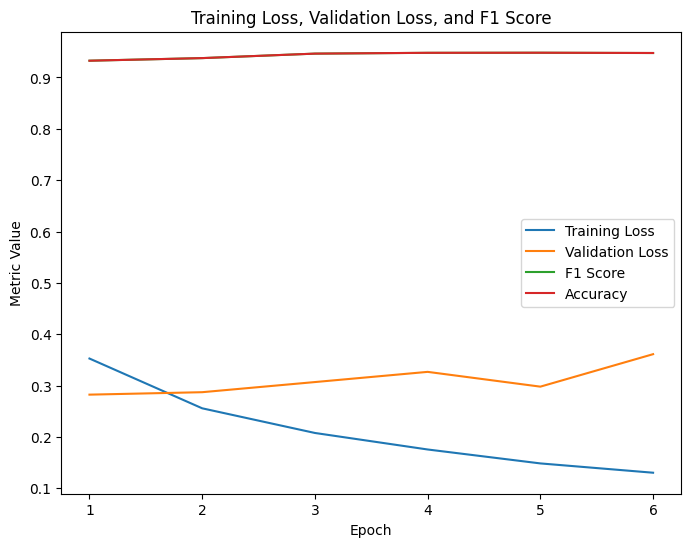

Epoch                 Training Loss        Validation Loss      F1 Score            Accuracy              Precision
--------------------  -------------------  -------------------  ------------------  ------------------  -----------
1                     0.3527025775462492   0.2824026430033013   0.9325849710314554  0.9325764192139738     0.932596
2                     0.25579717515683953  0.2871643876866104   0.937618734072753   0.937618734072753      0.937619
3                     0.20778820466066025  0.3068972861677764   0.9463580032840587  0.9463580032840587     0.946358
4                     0.17562611706454867  0.3267478724095954   0.9479127930206196  0.9479127930206196     0.947913
5                     0.14850201313283612  0.2979726129758991   0.9480983023385335  0.9480983023385335     0.948098
6                     0.1303809368207227   0.36119779399647267  0.9475251518632218  0.9475251518632218     0.947525
Total Training Time                                                     

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/6441 [00:00<?, ?it/s]


KeyboardInterrupt



In [19]:
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold

k = 10  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store the evaluation metrics for each fold
training_loss_lists = []
validation_loss_lists = []
accuracy_lists = []
precision_lists = []
f1_score_lists = []

# Convert the multilabel indicator target to numpy array
targets = dataset_train.tensors[1].numpy()

# Perform multilabel k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(targets)):
    print(f"\nFold {fold+1}")
    train_sampler = SubsetRandomSampler(train_index)
    val_sampler = SubsetRandomSampler(val_index)

    # Create data loaders for training and validation
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=train_sampler)
    dataloader_val = DataLoader(dataset_train, batch_size=batch_size, sampler=val_sampler)

    # train_model(trainer, dataloader_train, dataloader_val, epochs, patience)

    try:
        train_model(trainer, dataloader_train, dataloader_val, epochs, patience)
    except Exception as e:
        print(f"Continue to the next fold {fold+1}: {str(e)}")
        continue

In [ ]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_val)
accuracy_per_class(predictions, true_vals)

In [ ]:
model.load_state_dict(
    torch.load(
        "Models/finetuned_bert_gpt_ft_epoch10.model", 
        map_location = torch.device('cuda')
    )
)
_, predictions, true_vals = evaluate(dataloader_train)
accuracy_per_class(predictions, true_vals)